In [33]:
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft
import cmath

In [34]:
%matplotlib widget
import matplotlib.pyplot as plt

In [35]:
###de_embadding = False # указать, нужен или не нужен
time_gating = True # указать, нужен или не нужен

### Импорт сырых данных из .s2p файла и перевод их в комплексные числа

In [36]:
data_object_without = pd.read_csv('C:\\Users\\isvoropaev\Desktop\\python_codes\\post_processing_RIS\\250923\\Without_bias_mirror.s1p', 
                            sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS12', 'ImS12'])

data_object_1A = pd.read_csv('C:\\Users\\isvoropaev\Desktop\\python_codes\\post_processing_RIS\\250923\\2.8V_1A_bias_mirror.s1p', 
                            sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS12', 'ImS12'])

data_object_1_5A = pd.read_csv('C:\\Users\\isvoropaev\Desktop\\python_codes\\post_processing_RIS\\250923\\4.25V_1.5A_bias_mirror.s1p', 
                            sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS12', 'ImS12'])

data_object_2A = pd.read_csv('C:\\Users\\isvoropaev\Desktop\\python_codes\\post_processing_RIS\\250923\\5.65V_2A_bias_mirror.s1p', 
                            sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS12', 'ImS12'])

data_free = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\250923\\scan\\Free\\52deg.s1p', 
                        sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS12', 'ImS12'])

In [37]:
data_object_1A.head() # Смотрим корректность импорта данных

,Frequency,ReS12,ImS12
0,2.000000e+10,-0.005960,0.025671
1,2.001000e+10,0.007186,0.025562
2,2.002000e+10,0.020216,0.018946
3,2.003000e+10,0.027285,0.006413
4,2.004000e+10,0.025710,-0.007232


Перевод данных в вид комплексных чисел

In [38]:
for dataset in [data_object_without, data_object_1A, data_object_1_5A, data_object_2A, data_free]: # это массив из указателей на соответствующие
    dataset['s12']=dataset['ReS12']+1j*dataset['ImS12']

Удаление исходных колонок

In [39]:
data_object_without = data_object_without.drop(['ReS12', 'ImS12'], axis=1)
data_object_1A = data_object_1A.drop(['ReS12', 'ImS12'], axis=1)
data_object_1_5A = data_object_1_5A.drop(['ReS12', 'ImS12'], axis=1)
data_object_2A = data_object_2A.drop(['ReS12', 'ImS12'], axis=1)
data_free = data_free.drop(['ReS12', 'ImS12'], axis=1)

In [40]:
data_object_2A.head() # просмотр нового датасета

,Frequency,s12
0,2.000000e+10,-0.007617+0.025149j
1,2.001000e+10,0.006570+0.026169j
2,2.002000e+10,0.018642+0.020124j
3,2.003000e+10,0.026046+0.007503j
4,2.004000e+10,0.025760-0.006478j


Создаем переменные, с которыми будем непосредственно работать (массивы формата `pd.Series`)

In [41]:
frequency = data_object_without['Frequency']

s12_object_without = data_object_without['s12']
s12_object_1A = data_object_1A['s12']
s12_object_1_5A = data_object_1_5A['s12']
s12_object_2A = data_object_2A['s12']
s12_free = data_free['s12']

### Предпросмотр графиков необработанных файлов

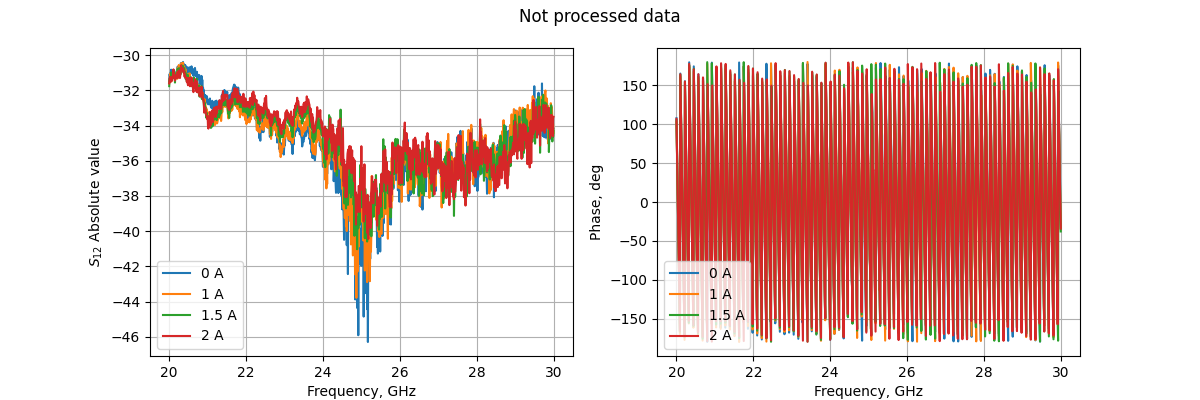

In [42]:
s_par = ['s12'] # Вести сюда названия S-параметров, которые нужны на графике в формате 'sij'
data = [data_object_without, data_object_1A, data_object_1_5A, data_object_2A] # Ввести сюда какие измерения нужны
name = ['0 A', '1 A', '1.5 A', '2 A']


'''Дальше  не трогать!!!'''
fig = plt.figure(figsize=(12,4))

ax_1 = fig.add_subplot(121)
ax_2 = fig.add_subplot(122)
for i, dataset in enumerate(data):
    for elem in s_par:
        ax_1.plot(dataset['Frequency']*1e-9, 20*np.log10(dataset[elem].apply(abs).to_numpy()), label=name[i])
        ax_2.plot(dataset['Frequency']*1e-9, np.degrees(dataset[elem].apply(cmath.phase)), label=name[i])

ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel(r"$S_{12}$ Absolute value")
ax_1.legend()
ax_1.grid()

ax_2.set_xlabel("Frequency, GHz")
ax_2.set_ylabel("Phase, deg")
ax_2.legend()
ax_2.grid()


fig.suptitle('Not processed data')
#plt.tight_layout()
plt.show()

### Time-Gating

In [43]:
N_fft = 2 ** 22 # количиство точек во временной области
# Должно иметь степень двойки для большей скорости и быть большем, чем количество частотных точек
T_max = 1 / (frequency[1]-frequency[0]) # продолжительность измеряемого импульса, определяется из количества измеряемых частотных точек
print(T_max)

1e-07


In [44]:
time = T_max*np.linspace(0, 1 + T_max, N_fft) # набор точек во временной области
time[-1] # последний элемент

1.0000001e-07

Просмотр S-параметров во временной области

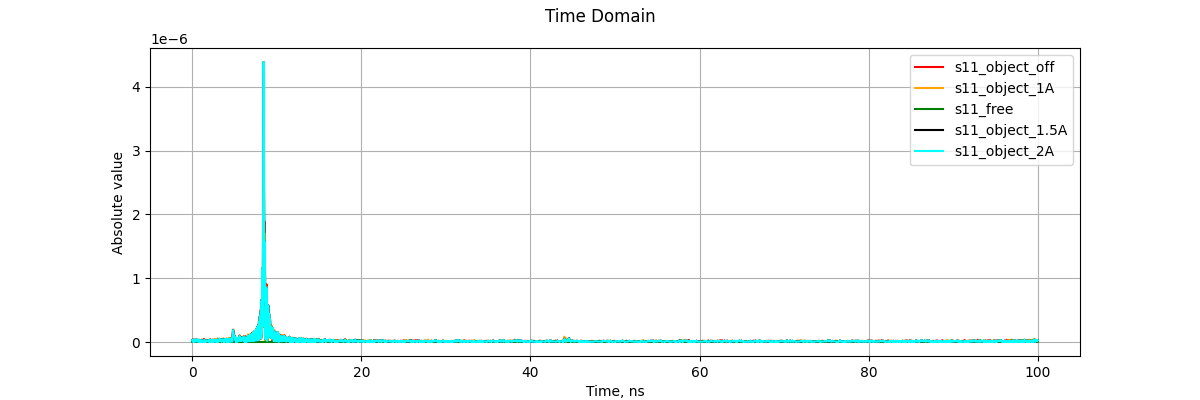

In [45]:
fig2 = plt.figure(figsize=(12,4))

ax_1 = fig2.add_subplot(111)
ax_1.plot(time*1e9, abs(ifft(s12_object_without.to_numpy(), n=N_fft)),'r', label='s11_object_off')
ax_1.plot(time*1e9, abs(ifft(s12_object_1A.to_numpy(), n=N_fft)),'orange', label='s11_object_1A')
ax_1.plot(time*1e9, abs(ifft(s12_free.to_numpy(), n=N_fft)),'g', label='s11_free')
ax_1.plot(time*1e9, abs(ifft(s12_object_1_5A.to_numpy(), n=N_fft)),'k', label='s11_object_1.5A')
ax_1.plot(time*1e9, abs(ifft(s12_object_1_5A.to_numpy(), n=N_fft)),'aqua', label='s11_object_2A')

ax_1.set_xlabel("Time, ns")
ax_1.set_ylabel("Absolute value")
ax_1.legend()
ax_1.grid()


fig2.suptitle('Time Domain')
plt.show()

In [46]:
gate_s21 = np.array([[0, 7], [10, 900]])*1e-9 # заполнить промежутками времени, которые необходимо вырезать в нс

In [47]:
def time_gate_s_param(gate: np.ndarray, s_par: pd.core.series.Series, n=N_fft, time=time):
    s = s_par.to_numpy()
    time_dom_s = pd.Series(ifft(s, n=n))
    for k in range(gate.shape[0]):
        if len(gate[k, :]) != 0:
            numbers = (time >= gate[k, 0]) & (time <= gate[k, 1])
            time_dom_s.loc[numbers] = 0
            #print(time_dom_s.head())
    s_new = fft(time_dom_s.to_numpy())
    s_new = s_new[0:len(frequency)]
    return pd.Series(s_new)

Проведение тайм-гейтинга

In [48]:
if time_gating == True:
    s12_object_without = time_gate_s_param(gate=gate_s21, s_par=s12_object_without)
    s12_object_1A = time_gate_s_param(gate=gate_s21, s_par=s12_object_1A)
    s12_object_1_5A = time_gate_s_param(gate=gate_s21, s_par=s12_object_1_5A)
    s12_object_2A = time_gate_s_param(gate=gate_s21, s_par=s12_object_2A)
    s12_free = time_gate_s_param(gate=gate_s21, s_par=s12_free)

In [49]:
s12_object_1A.shape # проверка, что число точек осталось таким же, как в исходных данных

(1001,)

Просмотр S-параметров после тайм-гейтинга

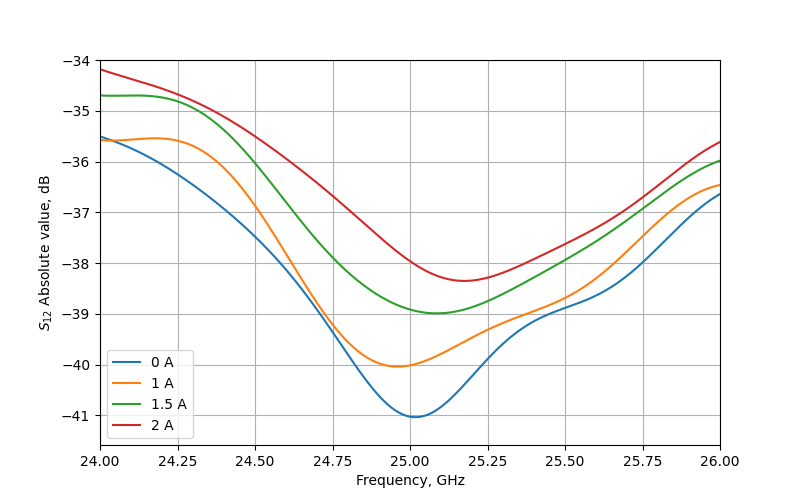

In [50]:
param = [ s12_object_without, s12_object_1A, s12_object_1_5A, s12_object_2A]
name = ['0 A', '1 A', '1.5 A', '2 A']

fig3 = plt.figure(figsize=(8,5))

ax_1 = fig3.add_subplot(111)

for i, s_par in enumerate(param):
    ax_1.plot(frequency*1e-9, 20*np.log10(s_par.apply(abs).to_numpy()), label=name[i])
ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel(r"$S_{12}$ Absolute value, dB")
ax_1.set_xlim(24, 26)
ax_1.set_ylim(top=-34)
ax_1.legend()
ax_1.grid()


#fig3.suptitle(r'$S_{12}$ ')
plt.show()

### Сравенние графиков с результатами CST

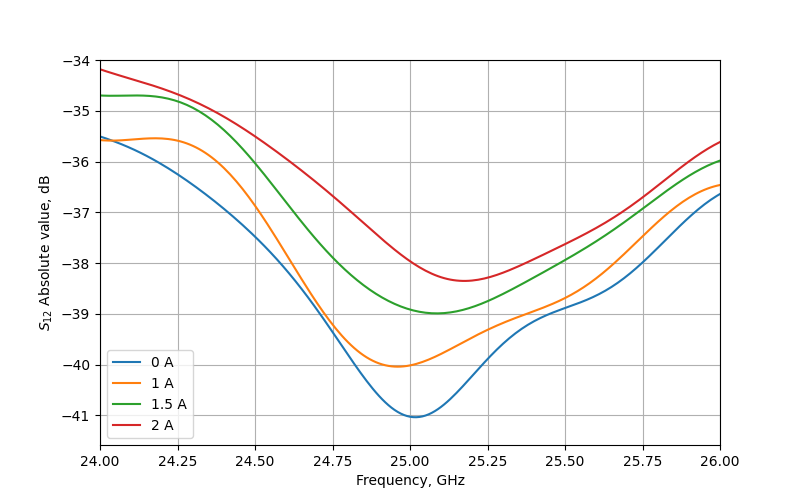

In [51]:
fig4 = plt.figure(figsize=(8,5))

ax_1 = fig4.add_subplot(111)

ax_1.plot(frequency*1e-9, 20*np.log10((s12_object_without-s12_free).apply(abs).to_numpy()), label='0 A')
ax_1.plot(frequency*1e-9, 20*np.log10((s12_object_1A-s12_free).apply(abs).to_numpy()), label='1 A')
ax_1.plot(frequency*1e-9, 20*np.log10((s12_object_1_5A-s12_free).apply(abs).to_numpy()), label='1.5 A')
ax_1.plot(frequency*1e-9, 20*np.log10((s12_object_2A-s12_free).apply(abs).to_numpy()), label='2 A')
ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel(r"$S_{12}$ Absolute value, dB")
ax_1.set_xlim(left=24, right=26)
ax_1.set_ylim(top=-34)
ax_1.legend()
ax_1.grid()


#fig4.suptitle('S12')
plt.show()

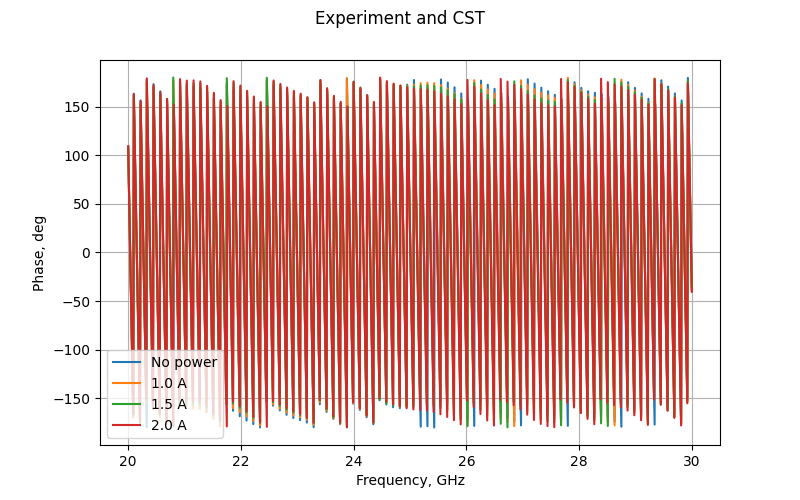

In [52]:
fig5 = plt.figure(figsize=(8,5))

ax_1 = fig5.add_subplot(111)

ax_1.plot(frequency*1e-9, np.degrees(pd.Series(s12_object_without - s12_free).apply(cmath.phase).to_numpy()), label='No power')
ax_1.plot(frequency*1e-9, np.degrees(pd.Series(s12_object_1A - s12_free).apply(cmath.phase).to_numpy()), label='1.0 A')
ax_1.plot(frequency*1e-9, np.degrees(pd.Series(s12_object_1_5A - s12_free).apply(cmath.phase).to_numpy()), label='1.5 A')
ax_1.plot(frequency*1e-9, np.degrees(pd.Series(s12_object_2A - s12_free).apply(cmath.phase).to_numpy()), label='2.0 A')
ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Phase, deg")
# ax_1.set_xlim(left=22, right=29)
ax_1.legend()
ax_1.grid()


fig5.suptitle('Experiment and CST')
plt.show()